In [3]:
import numpy as np 
from scipy import optimize
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
import os

from tqdm import * 
import pickle

import matplotlib.pyplot as plt 
%matplotlib inline 

In [4]:
def func(x): 
    
    return np.sum( np.sin(x) ) + np.exp((x[0]-1) * (x[1]+2))  

In [5]:
def sample_stiefel(n,k): 
    
    A = np.random.normal( 0, 1, (n, k) ) 
    
    def normalize(v): 
        return v / np.sqrt(v.dot(v)) 

    n = A.shape[1] 

    A[:, 0] = normalize(A[:, 0])  

    for i in range(1, n): 
        Ai = A[:, i] 
        for j in range(0, i): 
            Aj = A[:, j] 
            t = Ai.dot(Aj) 
            Ai = Ai - t * Aj 
        A[:, i] = normalize(Ai) 
        
    return A 

# our method, Stiefel's sampling

In [6]:
def stiefel( x, delta, k, n = 500 ): 


    V = sample_stiefel(n,k) 

    gs = [ n/delta/2 * ( func( x + delta * V[:,i]) - func( x - delta * V[:,i]) ) * V[:,i] for i in range(k) ] 

    g = np.mean( np.array( gs ) , axis = 0 ) 
    
    return g

In [17]:
def truth(x, n = 100): 
    
    H = np.diag( -np.sin(x) )
    C = np.exp((x[0] - 1)*(x[1] + 2))
    H[0,0] = H[0,0] + (x[1] + 2)**2 * C
    H[1,1] = H[1,1] + (x[0] - 1)**2 * C
    
    H[0,1] = C + (x[0] - 1)* (x[1] + 2) * C
    H[1,0] = C + (x[0] - 1)* (x[1] + 2) * C
    
    return H

In [56]:
n = 100; 

xs = [ np.array([0]*n), np.array([np.pi/4.]*n), -np.array([np.pi/2.]*n) ] 

locs = ['0', '0.25pi', 'n0.5pi']

rep = 10 

deltas = [ 0.1, 0.01, 0.001 ] 

for m in range(len(xs)): 

    x = xs[m]

    H_true = truth(x)

    for delta in deltas: 
        
        res = []
            
        for _ in range(rep): 

            res_inner = [] 

            for k in range(1,n+1): 

                V = sample_stiefel(n,k) 
                W = sample_stiefel(n,k) 

                H = 0
                for i in range(k):
                    for j in range(k): 

                        H = H + n**2/delta**2/8 * ( func( x + delta * V[:,i] + delta * W[:,j]) \
                                        - func( x - delta * V[:,i] + delta * W[:,j]) \
                                        - func( x + delta * V[:,i] - delta * W[:,j]) \
                                        + func( x - delta * V[:,i] - delta * W[:,j])) \
                                * ( np.outer(V[:,i], W[:,j]) + np.outer( W[:,j], V[:,i]) ) 

                H = H / k**2 
                
                error = np.sqrt( np.sum( ( np.linalg.svd( H - H_true )[1] )**2 ) ) 
                
                res_inner.append(error) 
                
            res.append(res_inner) 

        pickle.dump( res, open('./raw_results/for_trend_hess_x{0}_delta{1}'.format(locs[m],delta), 'wb' ) ) 
            
    

# plotting

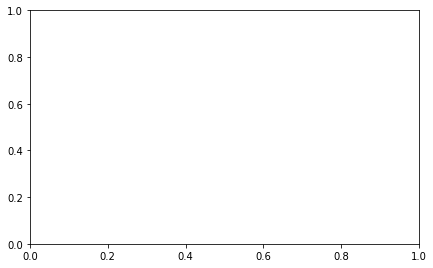

In [55]:
n = 100; 

xs = [ np.array([0]*n), np.array([np.pi/4.]*n), -np.array([np.pi/2.]*n) ] 

locs = ['0', '0.25pi', 'n0.5pi']

deltas = [ 0.1, 0.01, 0.001 ] 

for m in range(len(xs)): 
    
    x = xs[m]
    
    H = truth(x)
    
    for delta in deltas: 
            
        res = pickle.load( open('./raw_results/for_trend_hess_x{0}_delta{1}'.format(locs[m],delta), 'rb' ) )
        
#         error = [] 

#         for k in range(n): 
#             error.append( np.max(np.linalg.svd( res[ k ] - H )[1] ) ) 
            
#         theory_var_curve = ( np.array([np.linalg.norm( H, ord = 'fro' )**2 *(n**2/k**2 - 1) for k in range(1,n+1) ] )
#                    +\
#             np.array([delta**2 * np.max(np.linalg.svd( H )[1]) *( (n**4 - n**2*k**2) / (k**2) ) for k in range(1,n+1) ] ) \
#                    +\
#             delta**4 * n**4 / np.array( range(1,n+1) )**2 ) 
        
        error = np.mean(res,axis = 0) 
        std = 10 * np.std(res,axis = 0) 

        err, = plt.plot( np.log10( error ), label = 'lg of error' ) 
        
        plt.fill_between(range(n), np.log10( error ) , 
                         np.log10( error + std ) , alpha = 0.4)
        
        var_bound, = plt.plot( np.log10( np.array( theory_var_curve ) )[:], linestyle = 'dashed', color = 'red', 
                              label = 'lg of var. bound' ) 
        
#         plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4)) 

        plt.xlabel('$k$') 
        # plt.ylabel('log of error or sqrt. of variance') 

        plt.legend(handles = [err,var_bound], loc = 'lower left') 

        plt.tight_layout() 
#         plt.show() 

        plt.savefig('./figures/var_trend_hess_x{0}_delta{1}.png'.format(m,delta), dpi = 150) 
    
        plt.cla() 
    
        
#         plt.rcPara